**Instructions**  
1. pip install tdqm  because this is required for the progress bar built into the train() and make_conf_matrix() functions. 

2. Create test set dataloader

3. Load model and pre-trained weights (no training in this code) 

4. Run LIME experiments on random (or index defined) testset images

This code was adapted from https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb where marked "(see ref above)", otherwise it is original

In [22]:
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tqdm.notebook import tqdm # may need to pip install tqdm to get progress bar

In [23]:
from utils import *
from models import *
from dataset import *

In [24]:
device = torch.device('cpu')
if torch.cuda.is_available():
   device = torch.device('cuda')
print(device)

cuda


In [25]:
#create test dataloader only because this notebook is for LIME only
testset = FER2013Dataset('data/test.csv')
torch.backends.cudnn.benchmark = True
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                          shuffle=True, num_workers=0, pin_memory = True, drop_last = True)

**Load pre-trained CNN model**

In [27]:
# #create VGG face fer network 
net = Vgg_vd_face_fer_dag()

# Then amend network shape to make it suitable for 1 channel input (it already has 7 outputs). 

# Load the weights from the best MK trained model

net.conv1_1 = nn.Conv2d(1, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)) 
load_checkpoint('FER_Model__Final_Weights.pth', net, device)

Model's pretrained weights loaded!


In [28]:
#send net to device and set to eval mode
if device==torch.device('cuda'):
    net = net.to(device)
net.eval()

Vgg_vd_face_fer_dag(
  (conv1_1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_1): ReLU()
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_2): ReLU()
  (pool1): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_1): ReLU()
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_2): ReLU()
  (pool2): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_1): ReLU()
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_2): ReLU()
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_3): ReLU()
  (pool3): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mo

**LIME evaluation**

In [29]:
#create batch_predict function required by LIME to take a single example image as a batch
#(see ref above, with significant adaptation)
def batch_predict(example):
    example = torch.stack(tuple(torch.tensor(i) for i in example), dim=0).view(-1,3,224,224).to(device).float()  #-1 to match batch dim
    example = transforms.Grayscale(num_output_channels=1)(example)
    net.eval()
    probs = net(example)
    probs = F.softmax(probs, dim=1).detach().cpu().numpy() #.item()
    return probs

In [30]:
#define function to get a single example image to evaluate

def get_example_img(label=None):
    while True: 
        idx, example, emotion = testset[np.random.randint(len(testset))]
        ex_label = list(testset.classes)[emotion.detach().numpy().item()]
        if label is None or ex_label == label:
            eg_for_prob = example.view(1,1,224,224)
            probs = net(eg_for_prob.to(device)) 
            example = example.view(224,224).to(device)
            example = example.cpu().numpy()
            example = example.astype(np.double)
            probs =  F.softmax(probs, dim=1).detach().cpu().numpy()
            return idx, example, ex_label, probs.max()

In [31]:
#define function in order to re-examine specific images with different LIME params

def get_specific_img(idx): 
    idx, example, emotion= testset[idx]
    ex_label = list(testset.classes)[emotion.detach().numpy().item()]
    eg_for_prob = example.view(1,1,224,224)
    probs = net(eg_for_prob.to(device)) 
    example = example.view(224,224).to(device)
    example = example.cpu().numpy()
    example = example.astype(np.double)
    probs =  F.softmax(probs, dim=1).detach().cpu().numpy()
    return idx, example, ex_label, probs.max()

In [32]:
idx = 3092 # set idx if you want to run LIME on a specific image

Text(0.5, 1.0, 'index=3092, pred=surprise, prob=0.9998\n')

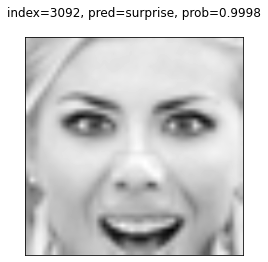

In [33]:
#display chosen image
# idx, example, label, prob = get_example_img()# gets a random image
idx, example, label, prob = get_specific_img(idx)  ## Use this line if you want a specific img (arg = image index)
plt.imshow(example)
plt.tick_params(
    axis='both',          
    which='both',     
    bottom=False,
    left=False,
    labelleft=False,
    labelbottom=False)        
plt.title(f'index={idx}, pred={label}, prob={prob:.4f}\n')

In [34]:
#create LIME explainer object
#(see ref above)
explainer = lime_image.LimeImageExplainer(verbose=True)
explanation = explainer.explain_instance(example, 
                                         batch_predict, # classification functiond defined above
                                         top_labels=7, #number of labels to explain  
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function


Intercept 0.10647523244192185
Prediction_local [-0.02898963]
Right: 0.0002756709
Intercept 0.39819772037189294
Prediction_local [-0.02223939]
Right: 0.0004517341
Intercept 0.053378971970984124
Prediction_local [0.26021776]
Right: 0.00064667943
Intercept 0.012399478694948576
Prediction_local [0.00265484]
Right: 0.0007665084
Intercept 0.23130246680239563
Prediction_local [0.323111]
Right: 0.018055756
Intercept 0.24642454702491356
Prediction_local [0.18041484]
Right: 0.112378195
Intercept -0.048178415627336296
Prediction_local [0.28483059]
Right: 0.86742544


In [35]:
#create a list of labels in order of prediction probability
single_img = testset[idx][1].reshape(1, 1, 224, 224).to(device)
y_probs=net(single_img)
probs = torch.topk(y_probs, y_probs.shape[1])[0].detach().cpu().numpy()
probs = probs.tolist()[0]
prob_order = torch.topk(y_probs, y_probs.shape[1])[1]
prob_order = prob_order.tolist()[0]

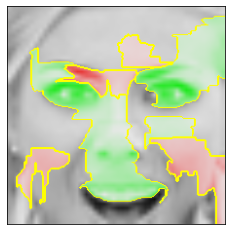

surprise


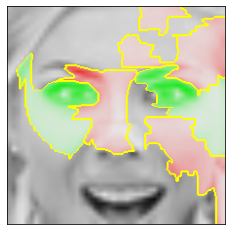

fear


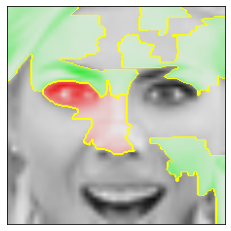

angry


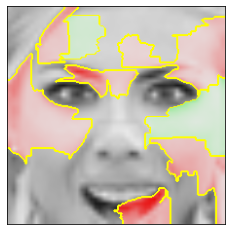

happy


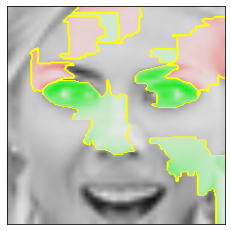

neutral


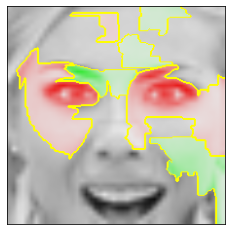

disgust


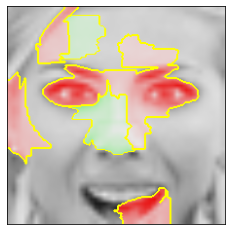

sad


In [37]:
#plot explanation mask over original image for each class, in order of prediction probabiity
#(see ref above, with significant adaptations)
for i in range(0,7):
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[i], positive_only=False, num_features=10, hide_rest=False)
    temp2=(temp*65.02+129.47)/255 # denomalise so it displays properly
    img_boundry1 = mark_boundaries(temp2, mask)
    plt.imshow(img_boundry1)
    # plt.title(label+'\n')
    plt.tick_params(
        axis='both',          
        which='both',     
        bottom=False,
        left=False,
        labelleft=False,
        labelbottom=False)
    plt.show()
    print(testset.classes[prob_order[i]])